In [38]:
import os
import copy
import pickle
import numpy as np
import glob

# matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse

# astropy
from astropy.io import fits
from astropy.nddata import Cutout2D
from astropy.utils.data import download_file
from astropy.coordinates import SkyCoord, Angle
from astropy import wcs
from astropy.table import Table,vstack
import astropy.units as u
import matplotlib.pyplot as plt 

import sncosmo

import sys
# so can find module one dir back; don't need to explicitly put .py into each subfolder 
sys.path.append("../..")
from candels_galaxy_surveys import galaxy_catalog,galaxy_survey
import update_galaxy_survey

# so can find script for host ellipses 
sys.path.append("../../visualize_hosts/")
from sn_cutout import ellipse

In [29]:
candels = pickle.load(open('delz_candels.pkl','rb'))

In [35]:
GND13Bid = candels[-1]

delz = GND13Bid[0]
nearby = GND13Bid[1][1]
host = GND13Bid[1][2]
lc = GND13Bid[1][3]

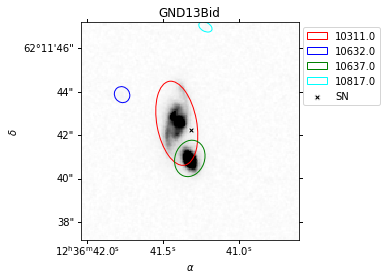

In [6]:
nick = GND13Bid[1][0]['name'] 
# the SN skycoord location
sn_loc = SkyCoord(GND13Bid[1][0]['RA'],GND13Bid[1][0]['DEC'],unit = (u.hourangle,u.deg))


# updating the surveys
update_near = update_galaxy_survey.update_survey(nearby)
update_host = update_galaxy_survey.update_survey(host[0])

# renaming for clarity
nearby = update_near
host = [update_host,host[1],host[2]]

# getting list of the ids, elliptical parameters for each nearby for this SN
ids = [i for i in nearby.mass[nearby.ids]]
nearby_coords = [i for i in nearby.gal_skycoords()]
a_ellipse = [np.float(i) for i in nearby.photom[nearby.a_ellip]]
b_ellipse = [np.float(i) for i in nearby.photom[nearby.b_ellip]]
theta_ellipse = [np.float(i) for i in nearby.photom[nearby.theta_ellip]]
gal_sources = [nearby.source]*len(nearby.photom)

# 5 element list, each element another x element list for a given SN with the x candidate parameters.
possible_hosts = [nearby_coords, a_ellipse, b_ellipse, theta_ellipse,ids,gal_sources]

# the ellipse 2nd argument wants a list with the x candidate parameters all together 
# ie not [[all coords], [all a], [all b], [all theta]] rather [[coords,a,b,theta],...]
possible_hosts = list(zip(possible_hosts[0],possible_hosts[1],possible_hosts[2],possible_hosts[3],possible_hosts[4],possible_hosts[5]))

ellipse(nick.lower()+'10x10.fits',possible_hosts,sn_loc,title=nick,save=False,show=True,diverging=False,logscale=False,val_min = -.0046,val_max = .175 )

In [21]:
from astropy.table import hstack
print(hstack([nearby.mass[nearby.ids,nearby.redshift_names],nearby.physpar[nearby.zspec,nearby.zphot]]))
nearby.gal_skycoords()

  id    z     z_spec z_peak
----- ------ ------- ------
10311 1.5300  1.5253 1.5551
10632 0.9400 -1.0000 0.9414
10637 0.5900  0.5850 0.5280
10817 1.5600 -1.0000 1.5635


[<SkyCoord (ICRS): (ra, dec) in deg
     (189.172571, 62.195145)>, <SkyCoord (ICRS): (ra, dec) in deg
     (189.174063, 62.195508)>, <SkyCoord (ICRS): (ra, dec) in deg
     (189.172201, 62.194689)>, <SkyCoord (ICRS): (ra, dec) in deg
     (189.171774, 62.196375)>]

## GND13Bid published as CC at spec-z~0.585 

The spec-z comes from the host. The postage stamp image seems to show a spiral galaxy (possibly two distinct objects note the 'two cores') as likely host w/ the SN being just slightly off from the galaxy center. 

Based on published host location:
14530 ~ The spiral z = 0.585 (as the host)... photo-z 0.554, spec-z 0.585. 

I'm assuming but uncertain that the other large object at lower dec than spiral is what is referred to as the alt-host. ie that the alt-host isn't from considering the spiral object as two distinct objects which looks like it could possibly be. 
14567 ~ The ellip z = 0.548 (as alt-host)...  phot-z 1.43,spec-z 0.548

The SN has good lc fit for model Ic(CSP-2004fe) at Z~0.585. 

In my catalog:
10311 ~ The spiral z = 1.53 (assuming host) ... spec-z 1.5253,  phot-z 1.5551
10637 ~ The ellip z = 0.585 (assumed alt-host) ... phot-z 0.5280, spec-z 0.585

## My catalog redshift for the host spiral object disagrees with the published redshift. If need to update redshift to my significantly increased value will need to reevaluate type... Also my redshift of the elliptical agrees with published host however disagrees with alt-host. *Still not certain if evernote treats spiral as two distinct host/althost is source of disagreement or if althost is actually the elliptical.

Below I look at the sncosmo lc fits at my host redshift, they work for either the salt2 Ia or 2004fe Ic models. I don't know if they are reasonable though based on the actual brightness.

In [114]:
tab = lc[0]
dat = copy.copy(tab)

name =  'GND13Biden'

# quick check with photometry to see if the host z = 1.53 from my catalog is possible
# the chisq for the Ia is slightly smaller than the Ic CC 
#model = sncosmo.Model(source='salt2')
#model = sncosmo.Model(source='snana-2004fe')

# Only fit to these bands
tmp = list(np.arange(len(dat)))
for i in range(len(dat)):
    if dat[i]['band'] == 'F160W':
        tmp.remove(i)
    elif dat[i]['band'] == 'F125W':
        tmp.remove(i)
    else:
        continue
dat.remove_rows(tmp)


# setting redshift bounds
try:
    z = 1.525
    dz = 0.001
    zup = z + dz
    zlow = z - dz
except:
    pass


# include the dust extinction for lights path through milky way
model.add_effect(sncosmo.CCM89Dust(),'mw','obs')
try:
    ebv = np.float(tab.meta['MWEBV'][0])
    model.set(mwebv = ebv)
except: pass


# try to fit model
result,fitted_model=sncosmo.fit_lc(
    dat ,model,
        model.param_names,
        bounds={'z':(zlow,zup)})


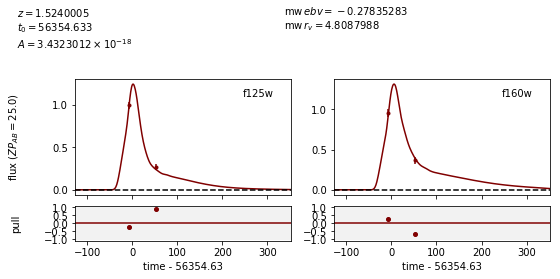

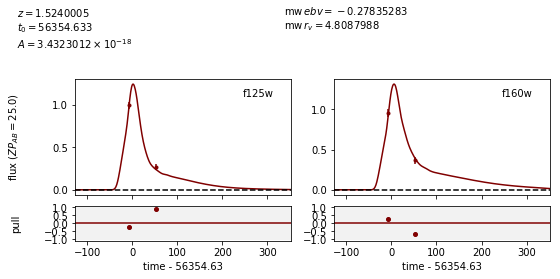

In [115]:
sncosmo.plot_lc(dat,fitted_model)

In [116]:
f160w = []
f125w = []


# data
for i in dat:
    if i['band'] == 'F160W':
        f160w.append(i)
    elif i['band'] == 'F125W':
        f125w.append(i)

from astropy.table import vstack
f160w = vstack([i for i in  f160w])
f125w = vstack([i for i in f125w])

# data points y
flux_f160w = [i for i in f160w['flux']] 
flux_f125w = [i for i in f125w['flux']]


#error bars
dflux_f160w = [i for i in  f160w['fluxerr']]
dflux_f125w = [i for i in f125w['fluxerr']]

# data points x
t160w = [i for i in f160w['time']]
t125w = [i for i in f125w['time']]

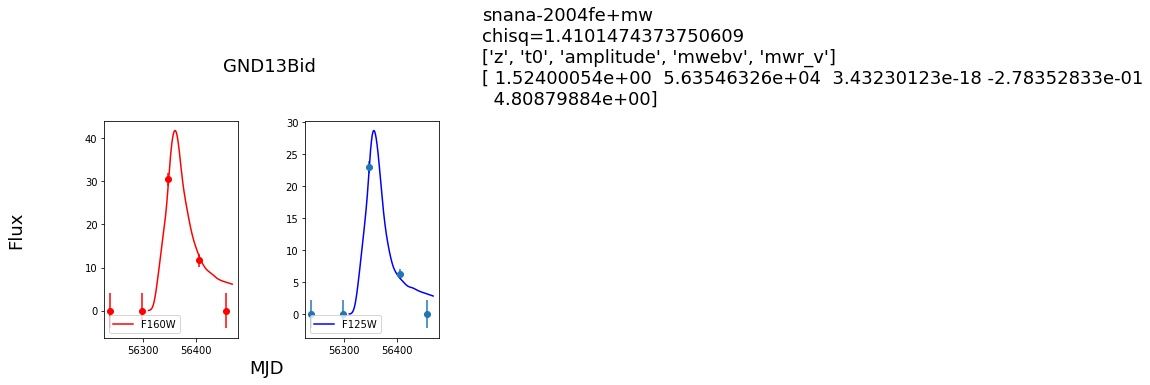

In [122]:
t0 = fitted_model.parameters[1]
t = np.linspace(t0 - 45,t0+115,10000)
fig, (ax1,ax2) = plt.subplots(1,2)
fig.text(0.5, 0.001, 'MJD', ha='center',size=18)
fig.text(-0.1, 0.5, 'Flux', va='center', rotation='vertical',size=18)
txtstr = str(fitted_model.description)+'\n'+'chisq='+str(result['chisq'])+'\n' + str(result['param_names']) + '\n' + str(result['parameters'])
fig.text(1.0,1.10,txtstr,va='center',size=18)

fig.text(0.4,1.05,'GND13Bid',size=18)


ax1.plot(t,fitted_model.bandflux('F160W',t,zp=27.5,zpsys='VEGA'),label='F160W',color = 'red')
ax1.errorbar(t160w,flux_f160w,yerr = dflux_f160w,fmt='o',color='red')

ax2.plot(t,fitted_model.bandflux('F125W',t,zp=27.5,zpsys='VEGA'),label='F125W',color='blue')
ax2.errorbar(t125w,flux_f125w,yerr=dflux_f125w,fmt='o')

plt.subplots_adjust(wspace=0.5)
ax1.legend()
ax2.legend()
